# Introduction to Bayesian Modeling with PyMC3
***
## 1. Mathematical Background
### 1.1 Bayes Theorem
#### Frequentist vs Bayesian
The essential difference between frequentist inference and Bayesian inference is the same as the difference between the two interpretations of what a “probability” means.

Frequentist inference is a method of statistical inference in which conclusions from data is obtained by emphasizing the frequency or proportion of the data.

Bayesian inference is a method of statistical inference in which Bayes’ theorem is used to update the probability for a hypothesis as more evidence or information becomes available.

#### Bayesian Approach to Data Analysis
Assume that you have a sample of observations (y1,y2,y3,...yn) of a random variable $Y \sim f(y|\theta)$, 
where $\theta$ is a parameter for the distribution. Here we consider $\theta$
 as a random variable as well. Following Bayes Theorem (its continuous version) we can write:
 
 $$ f(\theta|y) = \frac{f(y|\theta)f(\theta)}{f(y)}$$
 
 <li>the function $f(y|\theta)$ is called likelihood</li>
 <li>the function $f(\theta)$ is called prior</li>
 <li>the function $f(y)$ is independent of $\theta$</li>
 
 Therefore,
 
  $$ f(\theta|y) \propto likelihood * prior$$

## 2. Case Study: Medical Insurance Claim Distribution

In [2]:
from scipy.stats import expon,gamma
from numpy.random import seed
import pymc3 as pm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import gamma

## Sample distribution

In [3]:
df = pd.read_csv('Projects/P3/Processed_data/full_clean_data.csv',index_col=0)

In [176]:
amount = df.loc[df.amount>0].amount.dropna()

In [109]:
amount.shape

(663443,)

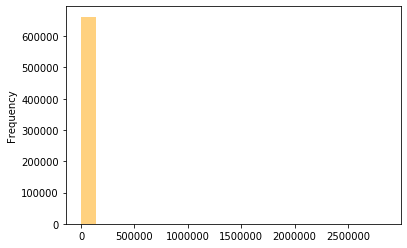

In [110]:
amount.plot.hist(bins=20,label='observed',alpha=0.5,color='orange')

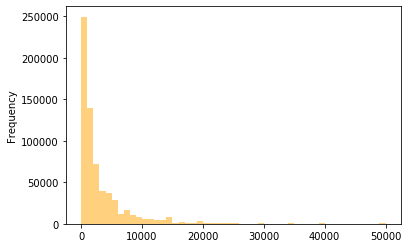

In [114]:
amount[amount<=50000].plot.hist(bins=50,label='observed',alpha=0.5,color='orange')

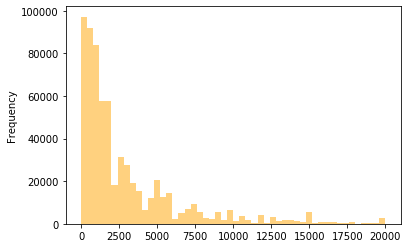

In [113]:
amount[amount<=20000].plot.hist(bins=50,label='observed',alpha=0.5,color='orange')

## Exponential distribution

$f(x) = \lambda e^{-\lambda x}$ (x > 0)

In [184]:
amount.min(),amount.max()

(0.1, 2850000.0)

In [185]:
mean = amount.mean() # mean = 1/lambda = scale
sd = amount.std()
round(mean,0),round(sd,0)

(4165.0, 18914.0)

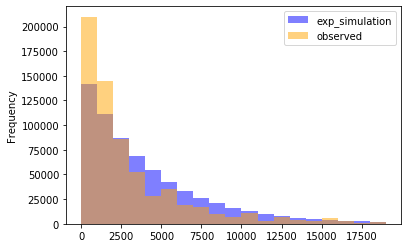

In [186]:
from numpy.random import exponential
exp = exponential(scale=mean,size=amount.shape[0])
plt.hist(exp, bins=range(0,20000,1000),label='exp_simulation',alpha=0.5,color='blue')
amount.plot.hist(bins=range(0,20000,1000),label='observed',alpha=0.5,color='orange')
plt.legend()

## Baysian Modeling with Monte Carlo Markov Chain

In [180]:
# use normal distribution as prior guess of distribution
with pm.Model() as model:
    mu_ = pm.Normal('mu', mu = mean, sigma=mean) # prior
    y_obs = pm.Exponential('y_obs', lam = 1/mu_, observed=amount) # likelihood
    trace = pm.sample(draws=500, tune = 500,chains=2) # draw samples from the MCMC chain

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:31<00:00, 63.39draws/s]


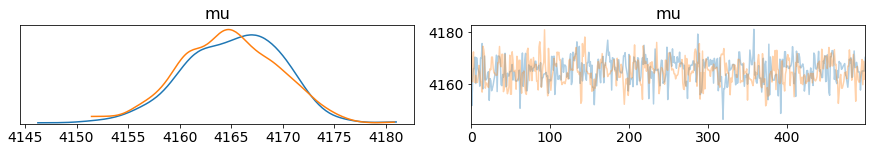

In [182]:
_ = pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c4b8d9190>],
      dtype=object)

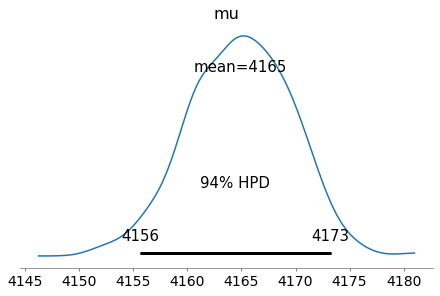

In [183]:
pm.plot_posterior(trace)

In [181]:
pm.summary(trace)

/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,4164.864646,4.812307,0.207061,4155.291925,4173.429992,456.725346,1.000493


## Gamma distribution simulation

$p(x) = x^{k-1}\frac{e^{-x/\theta}}{\theta^k\Gamma(k)},   x>0,   \Gamma(k) = (k-1)!$

$\mu = k\theta, \sigma^2 = k{\theta}^2$

$k= {\mu}^2/\sigma^2, \theta = \sigma^2/\mu$

In [187]:
# initial parameter of gamma distribution mean = k
k = (mean/sd)**2 # shape parameter, also called alpha
theta = sd**2/mean # scale parameter, also called 1/beta
k,theta, 1/theta

(0.04849069177407752, 85890.26648390642, 1.1642762805810756e-05)

In [188]:
gamma1 = gamma(shape=k, scale=theta,size=amount.shape[0])
dist = pd.DataFrame({})
dist['gamma'] = gamma1
gamma1 = dist['gamma'].loc[dist['gamma']<=50000]

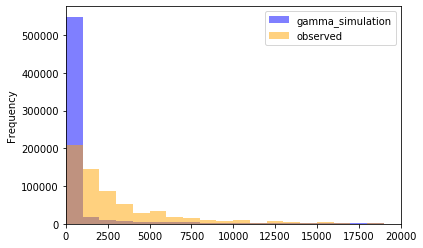

In [190]:
plt.hist(gamma1, bins=range(0,20000,1000),label='gamma_simulation',alpha=0.5,color='blue')
amount.plot.hist(bins=range(0,20000,1000),label='observed',alpha=0.5,color='orange')
plt.xlim(0,20000)
plt.legend()

## Baysian Modeling with Monte Carlo Markov Chain

### Gamma distribution

In [194]:
# baysian optimization of parameter
with pm.Model() as model:
    
    alpha_ = pm.Exponential('alpha', k) # prior
    rate_ = pm.Exponential('rate',1/theta) # prior
    
    y_obs = pm.Gamma('y_obs', alpha=alpha_, beta=1/rate_, observed=amount) # likelihood
    trace_2 = pm.sample(draws=500, tune = 500) # traw 2000 traces from posterior population

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rate, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [01:18<00:00, 25.57draws/s]
The acceptance probability does not match the target. It is 0.94187377163074, but should be close to 0.8. Try to increase the number of tuning steps.


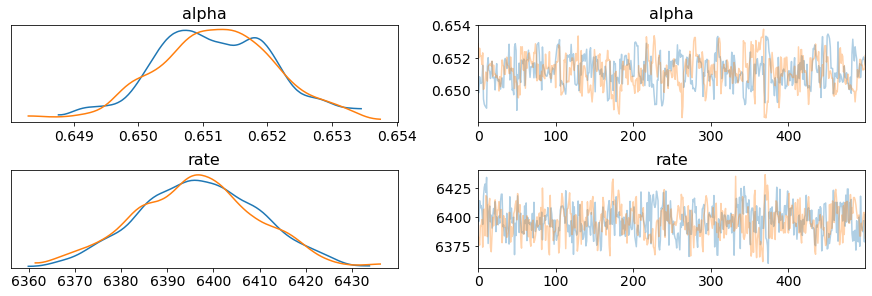

In [199]:
_ = pm.traceplot(trace_2)

In [195]:
pm.summary(trace_2)

/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.651174,0.000942,0.000051,0.649631,0.653346,311.015343,0.999019
rate,6396.408519,13.003123,0.618297,6370.588580,6420.945206,388.426767,0.999957


In [196]:
gamma2 = gamma(shape=0.651, scale=6396,size=amount.shape[0])
dist = pd.DataFrame({})
dist['gamma2'] = gamma2
gamma2 = dist['gamma2'].loc[dist['gamma2']<=50000]

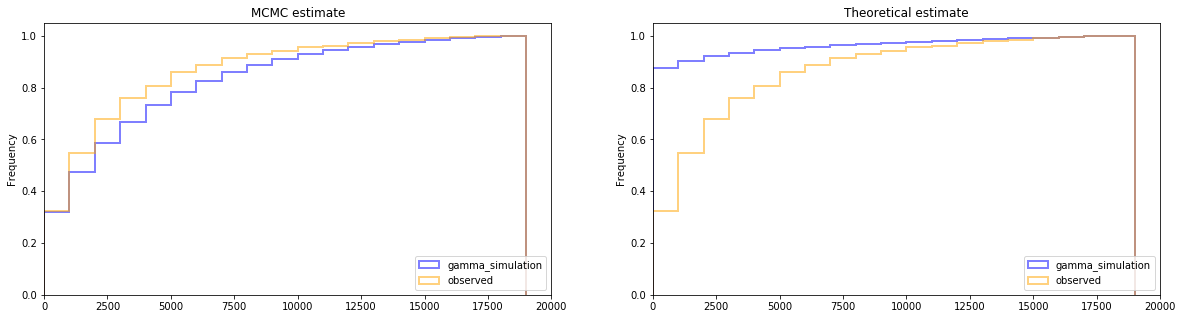

In [198]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)
ax1.hist(gamma2, bins=range(0,20000,1000),label='gamma_simulation',alpha=0.5,color='blue',\
         density=True, cumulative=True,histtype='step',linewidth=2)
amount.plot.hist(bins=range(0,20000,1000),label='observed',alpha=0.5,color='orange',ax=ax1,\
                 density=True, cumulative=True,histtype='step',linewidth=2)
plt.title('MCMC estimate')
plt.xlim(0,20000)
plt.legend(loc=4)

ax2 = fig.add_subplot(122)
ax2.hist(gamma1, bins=range(0,20000,1000),label='gamma_simulation',alpha=0.5,color='blue',\
         density=True, cumulative=True,histtype='step',linewidth=2)
amount.plot.hist(bins=range(0,20000,1000),label='observed',alpha=0.5,color='orange',ax=ax2,\
                 density=True, cumulative=True,histtype='step',linewidth=2)
plt.title('Theoretical estimate')
plt.xlim(0,20000)
plt.legend(loc=4)

In [33]:
from scipy import stats

In [200]:
stats.ks_2samp(amount,gamma1) # theoretical

Ks_2sampResult(statistic=0.7380272237712752, pvalue=0.0)

In [201]:
stats.ks_2samp(amount,gamma2) # MCMC

Ks_2sampResult(statistic=0.12255142770330785, pvalue=0.0)